# Problem definition

After pulling 100 tweets with the search term *Food Lion*, the main goal of this notebook is to use Natural Language Process to explore this little dataset and understand what people are saying about Food Lion on Twitter.

### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# Regular Expressions
import re

### Load the dataset

In [2]:
data = pd.read_csv('tweetsfl.csv', index_col=0)

In [3]:
# First check of the loaded dataset
data.head()

,name,location,date,text
0,James Rowland,"Savannah, GA",2020-11-11 23:16:39,@MattSenter @LolliDeals @FoodLion This is DOPE
1,MBR,NY,2020-11-11 23:11:43,Latest #My_MBR #retailnews: #FTC Move Puts #Fo...
2,Kate Metzger👩‍💻 Ł ⚡️🌎 🇺🇸 ✝️🎧🕊,"Texas, USA",2020-11-11 23:11:01,RT @MattSenter: Excited to announce the latest...
3,liter.,"Charlotte, NC",2020-11-11 23:05:06,"Dear @FoodLion, thank you for having some mosc..."
4,🐍avage,Broward,2020-11-11 23:01:33,@EyexRa @FoodLion This got me uncomfortable asf


### Data Exploratory Analysis

Let's start checking where are the tweets are coming from, using the location column

In [4]:
# Create a dataframe with the location
location = pd.DataFrame(data.location)

In [5]:
# Function to extract only the state of the location
def state(x):
    try:
        result = re.search('\S[A-Z]+', x).group()
    except:
        result= np.nan
    return result

In [6]:
# Applying the function to the location column
location['state'] = data.location.apply(state)

In [46]:
# Count values
state = location.state.value_counts(ascending=False)

In [49]:
# Manually correcting some values
location.state[[4,9]] = 'FL'
location.state[2] = 'TX'
location.state[12] = 'SC'
location.state[[20, 47]] = 'NY'
location.state[[7,44, 45, 70, 81, 85, 99]] = 'NC'
location.state[[18,19,49, 86]] = 'VA'
location.state[[52, 59, 48]] = 'TN'
location.state[[13, 21, 22, 23, 26, 27, 28, 31, 33, 74]] = np.nan

In [51]:
# Re-Run Count values for visualization
state = location.state.value_counts(ascending=False)

### Where are the People tweeting from?

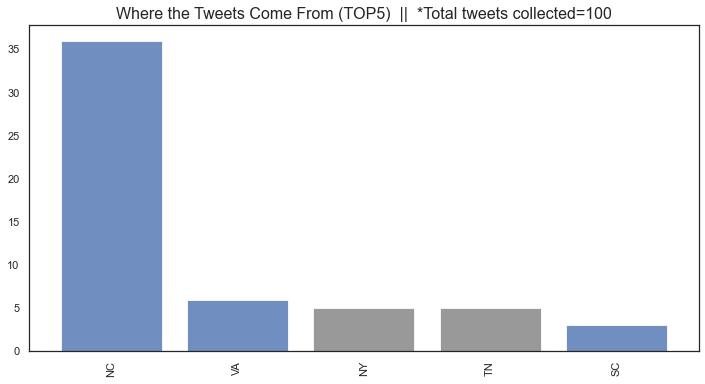

In [52]:
# Barplot TOP5 states with more tweets
state.head(5).plot.bar(alpha= 0.8, width=0.8,
                       color=['b','b', 'gray','gray', 'b'],
                       figsize=(12,6))
plt.title('Where the Tweets Come From (TOP5)  ||  *Total tweets collected=100', size=16)
plt.show()

In [53]:
# location in the map
import folium

In [54]:
# transform to dataframe pandas
state = pd.DataFrame(state).reset_index()

In [74]:
# Rename columns
state.columns = ['state', 'tweets']

In [66]:
# Readt table with USA states coordinates and put it in a pandas df
coord_states = pd.read_html('https://www.latlong.net/category/states-236-14.html')
coord_statesdf = pd.DataFrame(coord_states[0])

In [102]:
# Add Lat and Lon information
state['lat'] = coord_statesdf.Latitude[[48, 26, 7, 25, 40, 18, 43, 32, 28, 45, 22, 33, 36, 3]].reset_index(drop=True)
state['lon'] = coord_statesdf.Longitude[[48, 26, 7, 25, 40, 18, 43, 32, 28, 45, 22, 33, 36, 3]].reset_index(drop=True)

In [103]:
# Plot the places where tweets come from
m = folium.Map(location= [35.227085, -80.843124], zoom_start=5)


for i in range(state.shape[0]):
    radius = int(state['tweets'][i])
    loc = [state['lat'][i], state['lon'][i]]
    pop = str(state['state'][i]) +' '+ str(state['tweets'][i]) + '% tweets'
    folium.CircleMarker(radius=radius, location=loc, popup=pop, color='blue', fill=True).add_to(m)

m

---

Next step is to check what **day of the week** is the busiest and also the **hour of the day** when people tweet more about Food Lion

In [104]:
# converting date column to datetime for better manipulation
data['date'] = pd.to_datetime(data.date)

In [105]:
data.dtypes

name                object
location            object
date        datetime64[ns]
text                object
dtype: object

In [106]:
date = pd.DataFrame({'location':location.state, 'date':data.date})

In [107]:
# Extracting Hour and Weekday from the date column
date['hour'] = date.date.apply(lambda x: x.hour)
date['weekday'] = date.date.apply(lambda x: x.day_name())

In [108]:
date.head()

,location,date,hour,weekday
0,GA,2020-11-11 23:16:39,23,Wednesday
1,NY,2020-11-11 23:11:43,23,Wednesday
2,TX,2020-11-11 23:11:01,23,Wednesday
3,NC,2020-11-11 23:05:06,23,Wednesday
4,FL,2020-11-11 23:01:33,23,Wednesday


### What time people are tweeting more?

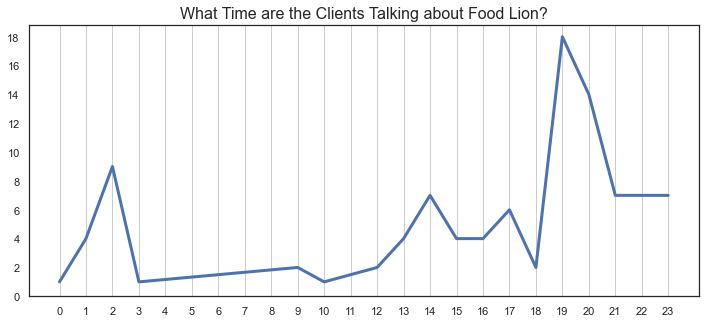

In [109]:
# Plot busiest hours in a day
plt.subplots(figsize=(12,5))
plt.plot(date.hour.value_counts().sort_index(), lw=3)
plt.title('What Time are the Clients Talking about Food Lion?', size=16)
plt.grid(axis='x')
plt.xticks(range(24))
plt.yticks(range(0,20,2))
plt.show()

Interesting to notice that there is a top at 2am. But as expected, lunch time (*between 13-14*) and dinner time (*between 19-20*) are when people usually tweet more, probably because they've just been to a Food Lion store.

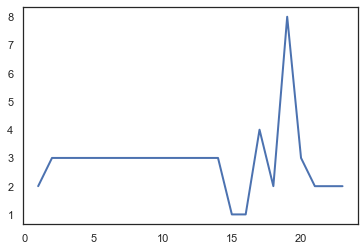

In [110]:
# People in North Carolina What Time they tweet more
plt.plot(date[date.location=='NC'].hour.value_counts().sort_index(), lw=2);

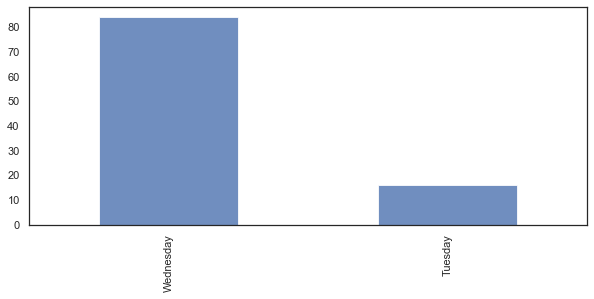

In [111]:
# We only have 100 tweets between November 10-11, so it won't matter too much. We would need more information for this analysis.
date.weekday.value_counts().plot.bar(alpha=0.8, figsize=(10,4));

### Natural Language Proceess

### Imports

In [112]:
# Natural Language processing
import re
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santos@us.ibm.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
# Extracing only text data from the dataset
df = data.drop(['name', 'location', 'date'], axis=1)

In [114]:
# Removing all of the special characters from the text
df['text'] = df.text.str.replace('[!@#$%&*+=)()/:]','')
# Removing RT, https from the text
df['text'] = df.text.str.replace('RT|https|forward','')

In [115]:
# All text to lower case
df['text'] = df.text.str.lower()

In [116]:
df

,text
0,mattsenter lollideals foodlion this is dope
1,latest my_mbr retailnews ftc move puts foodlio...
2,mattsenter excited to announce the latest fro...
3,"dear foodlion, thank you for having some mosca..."
4,eyexra foodlion this got me uncomfortable asf
...,...
95,jajensenphd ashleykav uncbullpen fletcherjones...
96,foodlionnews congratulations to goheels for h...
97,_ttopnotch girl i miss you moreee i was just t...
98,packathletics for every sack the packfootball...


In [117]:
# Load stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [118]:
txt = ' '.join(df.text)

# Tokenize abstracts
tokens = word_tokenize(txt)

# Cleaning punctuation
exclude = set(string.punctuation)
tokens1 = [word for word in tokens if word not in exclude]

# Removing stopwords
text_clean = [word for word in tokens1 if word not in stopwords]

### What people are saying about Food Lion?

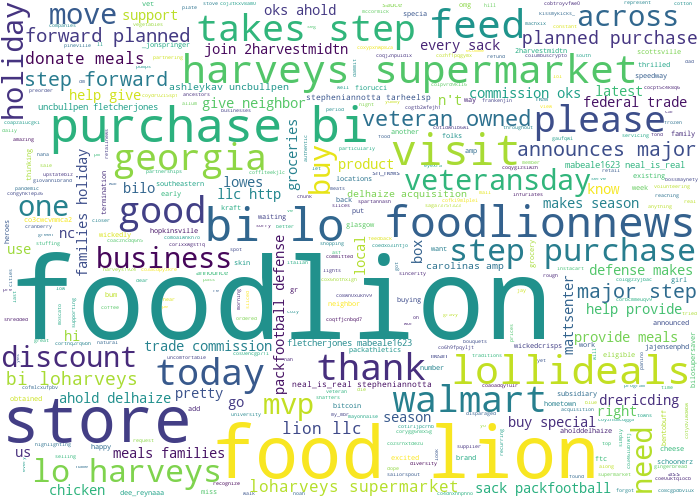

In [122]:
# WordCloud
from wordcloud import WordCloud

# Generate the text
text = ' '.join(text_clean)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=350, contour_width=3,
                      contour_color='steelblue', width=700, height=500)

# Generate a word cloud
wordcloud.generate(text)

# Visualize the word cloud
wordcloud.to_image()

In [123]:
# Count most frequent words
counts = Counter(text_clean)
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()

# Correct column names
counts_df.columns = ['word','frequence']

# Sort Values
counts_df.sort_values(by='frequence', ascending=False, inplace=True)

In [124]:
counts_df.drop([2,91,92,29,35,164], axis=0, inplace=True)

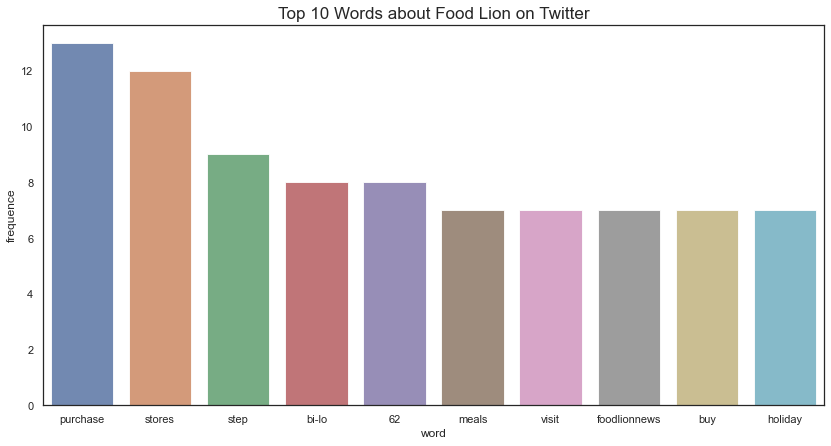

In [125]:
# Plot the 5 most frequent words
plt.figure(figsize=(14,7))
sns.barplot(x='word', y= 'frequence', data=counts_df.head(10), alpha=0.85)
plt.title('Top 10 Words about Food Lion on Twitter', size=17)
plt.show()

### LDA Modeling

In [126]:
# Extracing only text data from the dataset
df = data.drop(['name', 'location', 'date'], axis=1)
# Removing all of the special characters from the text
df['text'] = df.text.str.replace('[!@#$%&*+=)()/:]','')
# Removing RT, https from the text
df['text'] = df.text.str.replace('RT|https|forward','')
# All text to lower case
df['text'] = df.text.str.lower()

In [127]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

In [128]:
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df.text)

In [158]:
# Parameters
number_topics = 4
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [159]:
# Function to Print each category and its words
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_index, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_index}:")
        print(" , ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [160]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
foodlion , lo , bi , purchase , neighbor , supermarkets , takes , harveys , step , acquisition

Topic #1:
good , business , veteransday , veteran , owned , foodlion , support , nc , wickedcrisps , wickedly

Topic #2:
food , lion , foodlion , stores , 00 , foodlionnews , purchase , 62 , step , bi

Topic #3:
foodlion , 2harvestmidtn , walmart , lollideals , holiday , buy , visit , meals , join , families


### Analisys N-grams

N-grams are 'n' words that are used in sequence, together in a text. So, for example, a Bigram are two words used together in a text (e.g. cozy apartment). Trigrams are three words used in sequence (e.g. upper east side). Analysing those words can bring us more understanding of the reviews, as we can put the words in a context.

In [132]:
# Getting the Bigrams
buscaBigramas = nltk.collocations.BigramCollocationFinder.from_words(text_clean)

In [133]:
# Counting the frequence
bigrama_freq = buscaBigramas.ngram_fd.items()

In [134]:
# Putting in a dataframe
FreqBigramas = pd.DataFrame(list(bigrama_freq), 
                               columns = ['Bigram', 'Freq']).sort_values(by = 'Freq', ascending = False)

In [135]:
# Visualize the result
FreqBigramas.head(10)

,Bigram,Freq
113,"(food, lion)",20
360,"(visit, foodlion)",6
123,"(step, purchase)",5
205,"(purchase, 62)",5
126,"(harveys, supermarkets)",5
125,"(bi-lo, harveys)",5
122,"(takes, step)",5
124,"(purchase, bi-lo)",5
487,"(forward, planned)",4
361,"(foodlion, buy)",4


In [136]:
# Search and count Trigram frequence
buscaTrigramas = nltk.collocations.TrigramCollocationFinder.from_words(text_clean)
trigrama_freq = buscaTrigramas.ngram_fd.items()

In [137]:
# Putting in a dataframe
FreqTrigramas = pd.DataFrame(list(trigrama_freq), 
                                columns = ['Trigram','Freq']).sort_values(by = 'Freq', ascending = False)

In [138]:
# Visualize the result
FreqTrigramas.head(10)

,Trigram,Freq
128,"(bi-lo, harveys, supermarkets)",5
127,"(purchase, bi-lo, harveys)",5
126,"(step, purchase, bi-lo)",5
125,"(takes, step, purchase)",5
524,"(supermarket, stores, food)",4
520,"(planned, purchase, 62)",4
124,"(.foodlion, takes, step)",4
525,"(stores, food, lion)",4
523,"(bi-loharveys, supermarket, stores)",4
522,"(62, bi-loharveys, supermarket)",4


### Sentiment Analysis

In [163]:
# Import TextBlob
from textblob import TextBlob as tb

In [177]:
# List to store polarity scores
tweets = []

# Loop for to append all the analysis in a list
for tweet in df.text:
    #print(tweet)
    analysis = tb(tweet)
    polarity = analysis.sentiment.polarity
    tweets.append(polarity)
    #print(polarity)

In [176]:
# Sentiment Average
print('Sentiment Average for 100 Tweets between Nov 10th and 11th, 2020: {}'.format(np.mean(tweets)))

Sentiment Average for 100 Tweets between Nov 10th and 11th, 2020: 0.10557575757575759


## The End